In [1]:
# Import modules

#import wget
import constants as const 
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
import statistics

In [2]:
# Download dataset and load it as a Pandas DataFrame

#wget.download(https://opendata-renewables.engie.com//media/datasets/d543716b-368d-4c53-8fb1-55addbe8d3ad.zip)
#wget.download(https://opendata-renewables.engie.com//media/datasets/01c55756-5cd6-4f60-9f63-2d771bb25a1a.zip)

#data_turbines = pd.read_csv('../Dataset/la-haute-borne-data-2013-2016.csv',sep=';')
data_turbines1 = pd.read_csv('../Dataset/la-haute-borne-data-2013-2016.csv',sep=';')
data_turbines2 = pd.read_csv('../Dataset/la-haute-borne-data-2017-2020.csv',sep=';')
data_turbines = pd.concat([data_turbines1,data_turbines2])

print(data_turbines1.shape)
print(data_turbines2.shape)
print(data_turbines.shape)

(840380, 138)
(217588, 138)
(1057968, 138)


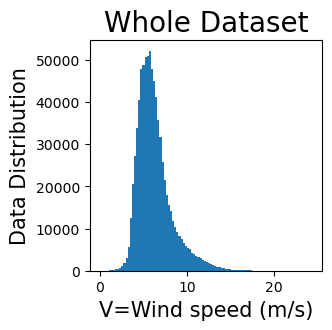

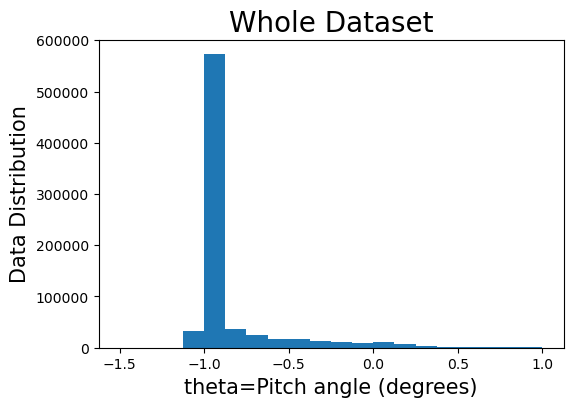

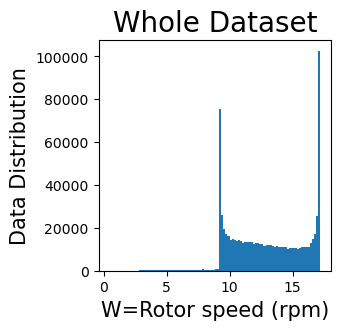

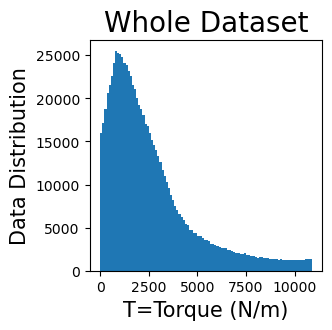

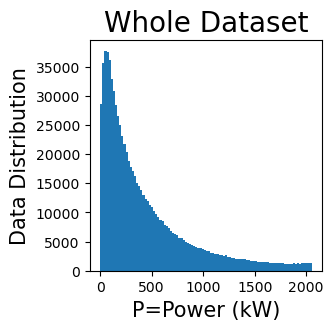

(803219, 5)


In [3]:
# Visualize data

from numpy import float64

#data_turbine1 = data_turbines[data_turbines["Wind_turbine_name"]=="R80711"]
#data_turbine2 = data_turbines[data_turbines["Wind_turbine_name"]=="R80721"]
#data_turbine3 = data_turbines[data_turbines["Wind_turbine_name"]=="R80736"]
#data_turbine4 = data_turbines[data_turbines["Wind_turbine_name"]=="R80790"]
#print(data_turbine1.shape)
#print(data_turbine2.shape)
#print(data_turbine3.shape)
#print(data_turbine4.shape)
#print(data_turbine1.head(5))

# Extract the desired variables
data_turbines = data_turbines[['Ws_avg','Ba_avg','Rs_avg','Rm_avg','P_avg']]

# Drop out all rows with NaN values
data_turbines = data_turbines.dropna()
data_turbines = data_turbines.dropna(axis=0)

# Remove data with negative torque, wind speed, rotor angular speed, or active power
data_turbines = data_turbines[ (data_turbines['Rm_avg'] > 0.0) ]
data_turbines = data_turbines[ (data_turbines['Ws_avg'] > 0.0) ]
data_turbines = data_turbines[ (data_turbines['Rs_avg'] > 0.0) ]
data_turbines = data_turbines[ (data_turbines['P_avg'] > 0.0) ]

""" # Remove outliers (but not for pitch angle)
#for col_name in ["Ws_avg","Ba_avg","Rs_avg","Rm_avg"]:
for col_name in ["Ws_avg","Rs_avg","Rm_avg"]:    
    q_low = data_turbines[col_name].quantile(0.05)
    q_hi  = data_turbines[col_name].quantile(0.95)
    data_turbines = data_turbines[(data_turbines[col_name] < q_hi) & (data_turbines[col_name] > q_low)] """

# Define inputs and outputs
X_data = data_turbines[['Ws_avg','Ba_avg','Rs_avg']]
Y_data = data_turbines[['Rm_avg','P_avg']]

# Convert data to numpy arrays
X_data = X_data.to_numpy(dtype='float64')
Y_data = Y_data.to_numpy(dtype='float64')
#print(X_data.shape)
#print(Y_data.shape)

# Distribution of the variables

plt.figure(figsize=(3,3))
plt.hist(X_data[:,0], bins=100)
plt.xlabel('V=Wind speed (m/s)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(X_data[:,1], range=[-1.5, 1],bins=20)
plt.xlabel('theta=Pitch angle (degrees)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

plt.figure(figsize=(3,3))
plt.hist(X_data[:,2], bins=100)
plt.xlabel('W=Rotor speed (rpm)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

plt.figure(figsize=(3,3))
plt.hist(Y_data[:,0], bins=100)
plt.xlabel('T=Torque (N/m)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

plt.figure(figsize=(3,3))
plt.hist(Y_data[:,1], bins=100)
plt.xlabel('P=Power (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

print(data_turbines.shape)

# Convert inputs to desired units
X_data[:,1] = X_data[:,1] * np.pi / 180.0   # pitch angle from degrees to rad
X_data[:,2] = X_data[:,2] * 2*np.pi / 60.0  # rotor speed from rpm to rad/s
Y_data[:,1] = Y_data[:,1] * 1000.0          # power from kW to W


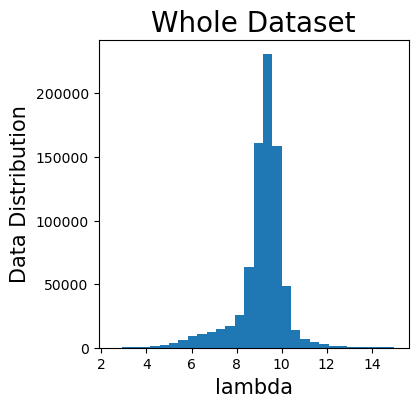

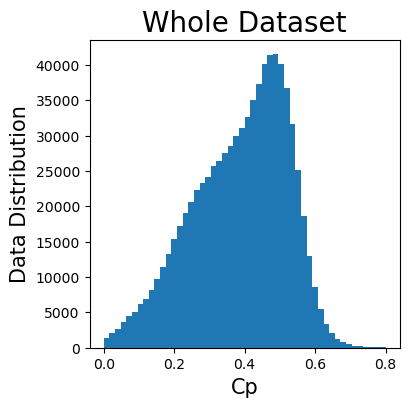

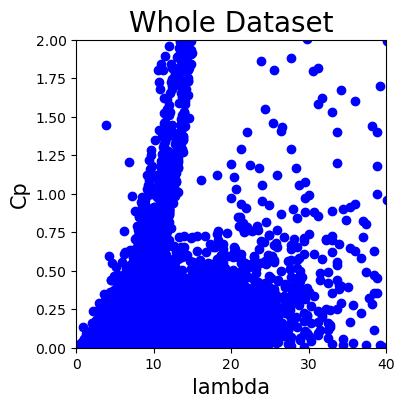

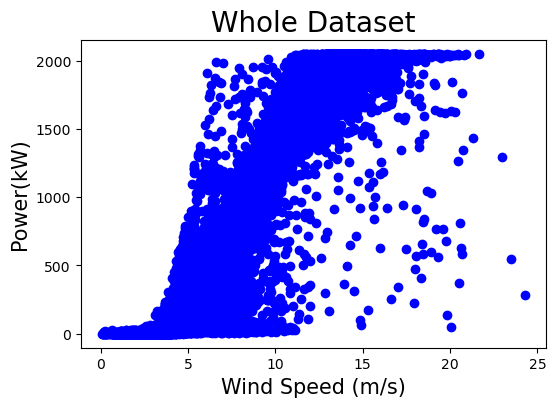

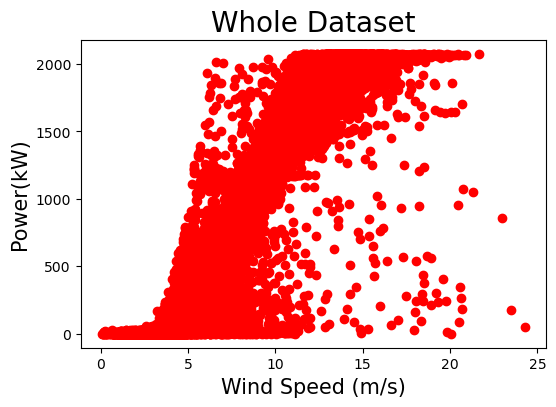

2.066349407097012
0.29997736627678917


In [12]:
# Check Cp for the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def Cp_fromT(Tgen, Vw, Wwt):

    Tt = Tgen * const.gear
    Pturbina = Tt* Wwt
    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp    

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

def Power_fromT( Tgen, Wwt):

    Pturbina = const.gear * Tgen * Wwt
    return Pturbina

""" def Power( Tgen, Vw, Wwt ):

    Cp = Cp_fromT(Tgen,Vw, Wwt)
    Pturbina = 0.5 * Cp * const.rho * const.A * Vw**3

    return Pturbina """
        
""" def Power( Tgen, Vw, Wwt ):

    Cp = compute_Cp(Tgen,Vw, Wwt)
    Pturbina = 0.5 * Cp * const.rho * const.A * Vw**3

    return Pturbina/1000 # convert from W to kW """

Cp_data = np.zeros(len(Y_data[:,0]))
lambd_data = np.zeros(len(Y_data[:,0]))
#Cp_data[:] = Cp_fromT(Y_data[:,0], X_data[:,0], X_data[:,2])
Cp_data[:] = Cp_fromP(Y_data[:,1], X_data[:,0])
lambd_data[:] = lambd(X_data[:,0], X_data[:,2])

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of Cp
plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

""" # Histogram of Cp
plt.figure()#figsize=(10,10))
plt.hist(Cp_fromT(Y_data[:,0], X_data[:,0], X_data[:,2]), range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show() """

# Plot Cp vs lambda
plt.figure(figsize=(4,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(lambd_data, Cp_data, 'bo')
#plt.xlim([2,15])
#plt.ylim([0,1])
plt.xlim([0,40])
plt.ylim([0,2])
plt.show()

""" # Plot Cp vs lambda
plt.figure()#figsize=(10,10))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(lambd_data, Cp_fromT(Y_data[:,0], X_data[:,0], X_data[:,2]), 'bo')
plt.xlim([2,15])
plt.ylim([0,1])
plt.show() """

#P_data = np.zeros(len(Y_data[:,0]))
#P_data = compute_P( Y_data[:,0],[X_data[:,0], X_data[:,1], X_data[:,2]] )

# Plot P vs V
plt.figure(figsize=(6,4))
plt.xlabel('Wind Speed (m/s)',fontsize=15)
plt.ylabel('Power(kW)',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(X_data[:,0], Y_data[:,1]/1000, 'bo')
#plt.xlim([0,200])
#plt.ylim([0,100])
plt.show()

# Plot P(from T) vs V
plt.figure(figsize=(6,4))
plt.xlabel('Wind Speed (m/s)',fontsize=15)
plt.ylabel('Power(kW)',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(X_data[:,0], Power_fromT(Y_data[:,0], X_data[:,2])/1000, 'ro')
#plt.xlim([0,200])
#plt.ylim([0,100])
plt.show()

# Differences between P(data) and P(from T)
P_diff = np.zeros(len(Y_data[:,1]))
P_diff = (Y_data[:,1] - Power_fromT(Y_data[:,0], X_data[:,2])) / Y_data[:,1]
P_diff = abs(P_diff) * 100
#P_diff = P_diff[ (P_diff < 500.0) ]
print(np.mean(P_diff))
print(median_abs_deviation(P_diff))


P_all = Y_data[:,1]
V_all = X_data[:,0]

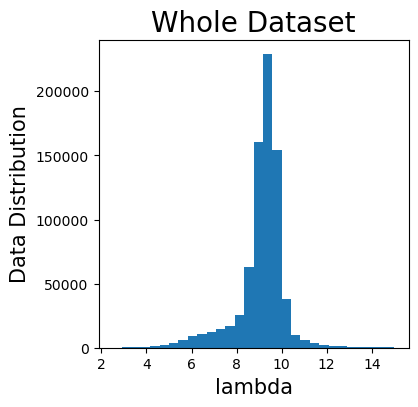

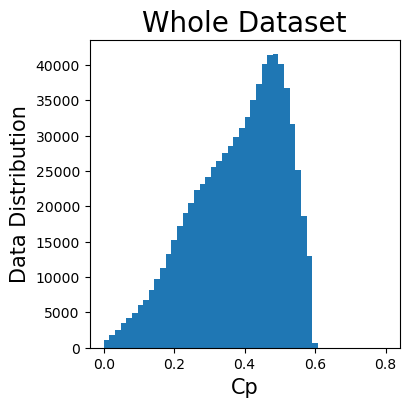

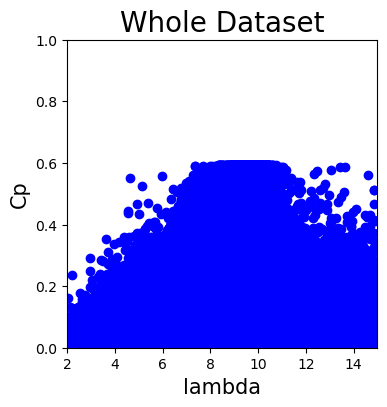

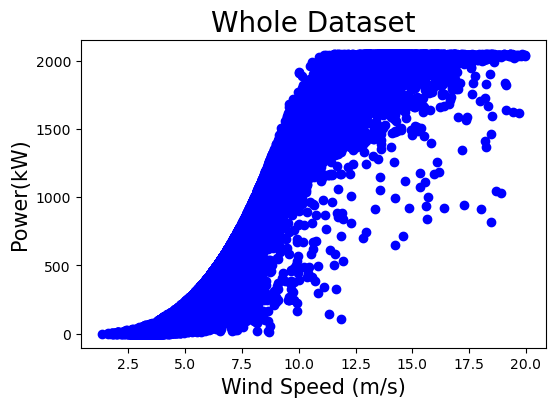

(777398, 3)


In [15]:
# Remove data with Cp>0.593
Cp_max = 0.593
X_data = X_data [ (Cp_data < Cp_max) ]
Y_data = Y_data [ (Cp_data < Cp_max) ]
lambd_data = lambd_data [ (Cp_data < Cp_max) ]
Cp_data = Cp_data [ (Cp_data < Cp_max) ]

# Revome data with lambd outside [2,15]
lmin = 2
lmax = 15
X_data = X_data [ (lmin<lambd_data) & (lambd_data<lmax) ]
Y_data = Y_data [ (lmin<lambd_data) & (lambd_data<lmax) ]
Cp_data = Cp_data [ (lmin<lambd_data) & (lambd_data<lmax) ]
lambd_data = lambd_data [ (lmin<lambd_data) & (lambd_data<lmax) ]

# Revome data with Vw>22
vmin = 0
vmax = 20
Y_data = Y_data [ (X_data[:,0] < vmax) ]
lambd_data = lambd_data [ (X_data[:,0] < vmax) ]
Cp_data = Cp_data [ (X_data[:,0] < vmax) ]
X_data = X_data [ (X_data[:,0] < vmax) ]

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of Cp
plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Plot Cp vs lambda
plt.figure(figsize=(4,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(lambd_data, Cp_data, 'bo')
plt.xlim([2,15])
plt.ylim([0,1])
plt.show()

# Plot P vs V
plt.figure(figsize=(6,4))
plt.xlabel('Wind Speed (m/s)',fontsize=15)
plt.ylabel('Power(kW)',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(X_data[:,0], Y_data[:,1]/1000, 'bo')
#plt.xlim([0,200])
#plt.ylim([0,100])
plt.show()

print(X_data.shape)

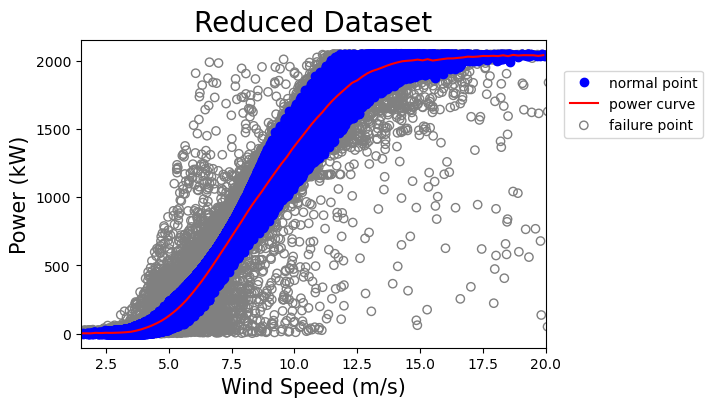

(767248,)


In [16]:
# Discard failed data from power curve

# Estimate the power curve with an iterative median estimation technique. 
nbins = 100
#percentage = 0.05
P_estimated = np.zeros(nbins)
V_estimated = np.zeros(nbins)
dv = (vmax-vmin)/nbins

P_estimated[0]=0.0
for i in range(1,nbins):
    vl = vmin + i*dv
    vr = vl + dv

    # Median of P in the bin i
    V_estimated[i] = (vl+vr)/2.0
    v_subset = (vl<X_data[:,0]) & (X_data[:,0]<vr)  # subset of v points of the bin
    #Pi = Y_data[:,1][(vl<X_data[:,0]) & (X_data[:,0]<vr)]
    Pi = Y_data[:,1][v_subset]                      # Power distribution of bin i
    if (len(Pi)>0):
        P_estimated[i]=statistics.median(Pi)
        #P_estimated[i]=statistics.mean(Pi)
    else:
        P_estimated[i]=P_estimated[i-1]


#Each point is removed if it is further than 5*sigma from the median at each bin
P_good = []
V_good = []
W_good = []
theta_good = []
T_good = []
for i in range(nbins):
    vl = vmin + i*dv
    vr = vl + dv

    if(P_estimated[i]>0.0):
        v_subset = (vl<X_data[:,0]) & (X_data[:,0]<vr)
        #p_condition = (np.abs(Y_data[:,1]-P_estimated[i])/P_estimated[i] < percentage )
        #p_condition = (np.abs(Y_data[:,1]-P_estimated[i])< 80000 )
        Pi = Y_data[:,1][v_subset]              # power distribution of bin i
        sigma = median_abs_deviation(Pi)
        p_condition = (np.abs(Y_data[:,1]-P_estimated[i]) < 5*sigma )

        P_good = np.append(P_good, Y_data[:,1][v_subset & p_condition])
        V_good = np.append(V_good, X_data[:,0][v_subset & p_condition])

        W_good = np.append(W_good, X_data[:,2][v_subset & p_condition])
        theta_good = np.append(theta_good, X_data[:,1][v_subset & p_condition])
        T_good = np.append(T_good, Y_data[:,0][v_subset & p_condition])          

""" X_data[:,0] = np.array(V_good[:],dtype='float64')
X_data[:,1] = np.array(theta_good[:],dtype='float64')
X_data[:,2] = np.array(W_good[:],dtype='float64')
Y_data[:,0] = np.array(T_good[:],dtype='float64')
Y_data[:,1] = np.array(P_good[:],dtype='float64') """

V_good = np.array(V_good[:],dtype='float64')
theta_good = np.array(theta_good[:],dtype='float64')
W_good = np.array(W_good[:],dtype='float64')
T_good = np.array(T_good[:],dtype='float64')
P_good = np.array(P_good[:],dtype='float64')

# Plot P vs V
plt.figure(figsize=(6,4))
plt.xlabel('Wind Speed (m/s)',fontsize=15)
plt.ylabel('Power (kW)',fontsize=15)
plt.title('Reduced Dataset',fontsize=20)
plt.scatter(V_all, P_all/1000,facecolors='none',edgecolors='grey', label='failure point')
plt.plot(V_good, P_good/1000,'bo',label='normal point')
#plt.plot(X_data_aux[:,0], Y_data_aux[:,1]/1000,'bo')
plt.plot(V_estimated, P_estimated/1000, 'r-',label='power curve')
plt.xlim([1.5,20])
#plt.ylim([0,100])
l1 = plt.legend(bbox_to_anchor=(1.04, 0.9), borderaxespad=0)
plt.show()

print(P_good.shape)


In [17]:
# Save reduced dataset in Wats, rads/s and rads for power, angular velocity and angle

data=np.zeros((len(V_good),5))
data[:,0] = V_good[:]
data[:,1] = theta_good[:]
data[:,2] = W_good[:]
data[:,3] = T_good[:]
data[:,4] = P_good[:]
print(data.shape)

import csv
header = ['V', 'theta', 'W', 'T', 'P']
with open('../Dataset/Dataset_reduced.csv','w',encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header 
    writer.writerow(header)

    # write multiple rows
    writer.writerows(data)

(767248, 5)


In [19]:
# Differences between P(data) and P(from T)
P_diff = np.zeros(len(P_good[:]))
P_diff = (P_good[:] - Power_fromT(T_good[:], W_good[:])) / P_good[:]
P_diff_abs = abs(P_diff) * 100
#P_diff = P_diff[ (P_diff < 500.0) ]
print(np.mean(P_diff_abs))
print(median_abs_deviation(P_diff_abs))
print(np.mean(P_diff))
print(median_abs_deviation(P_diff))


1.9986349312439822
0.30492904336648674
0.010673507825449216
0.005129970012325576


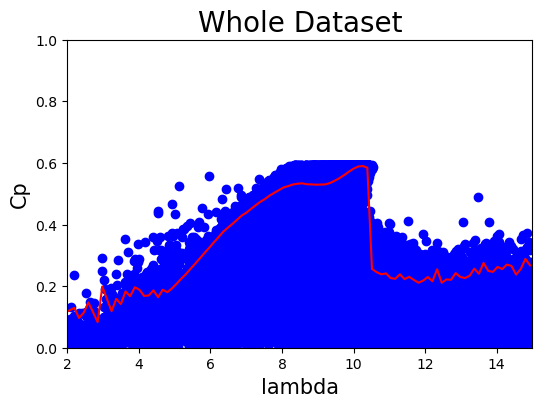

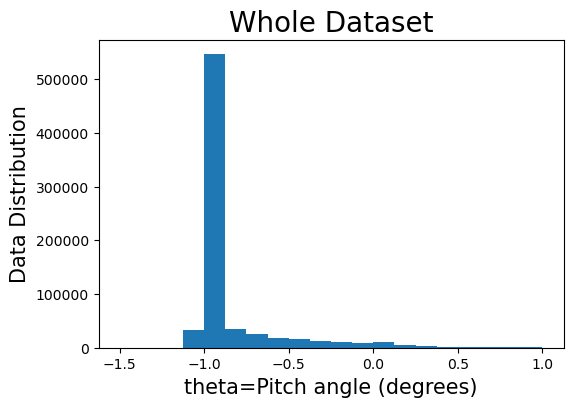

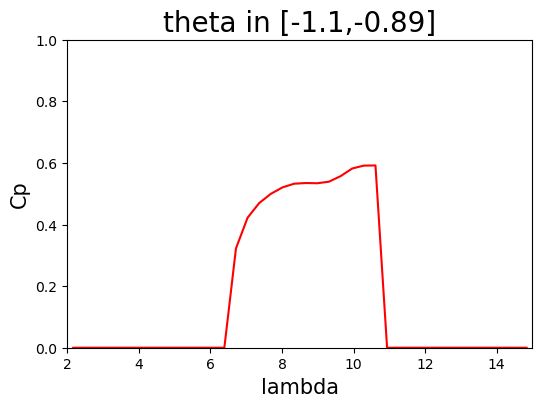

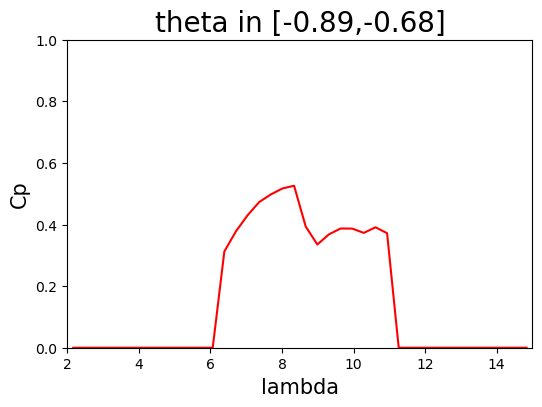

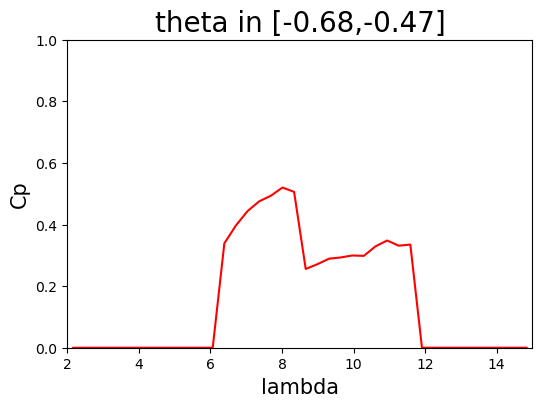

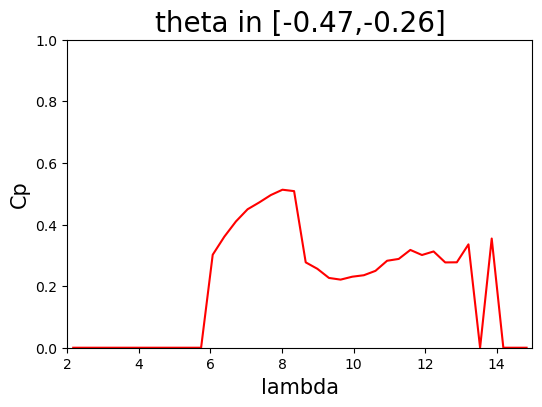

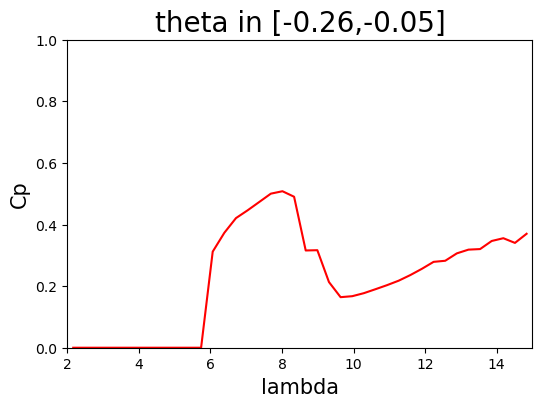

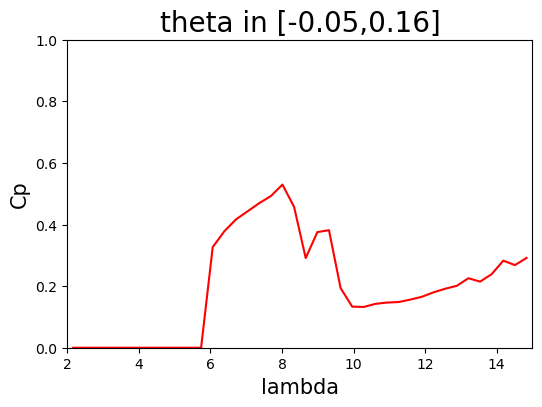

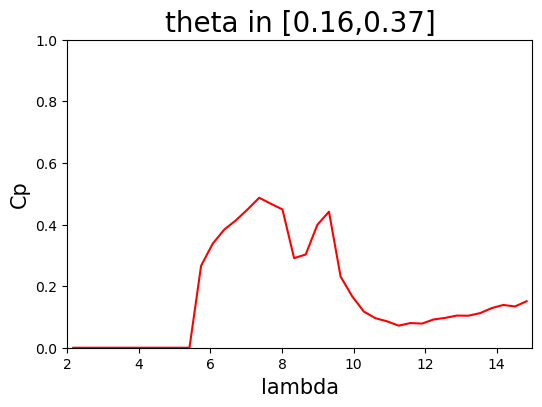

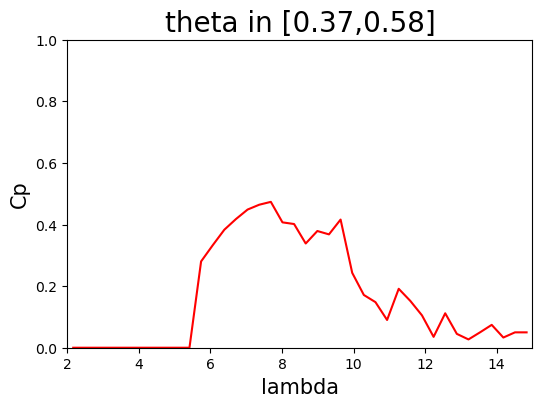

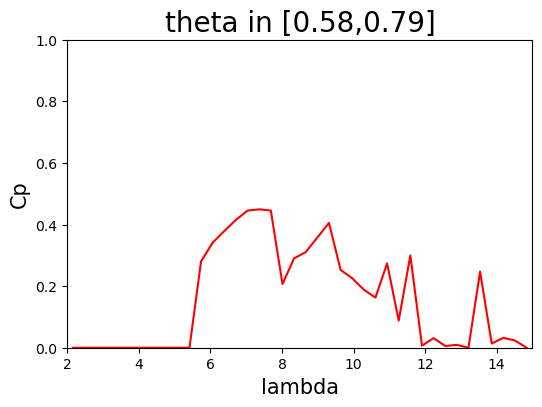

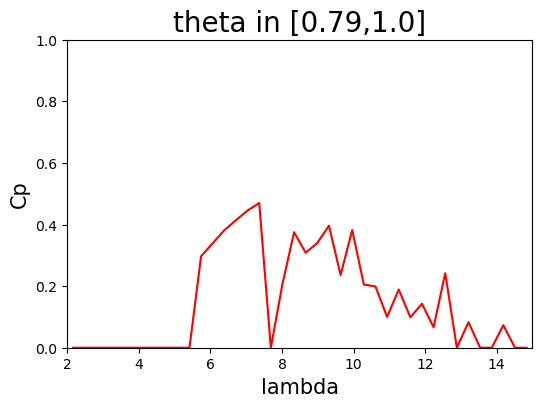

In [30]:
# Cp curve
Cp_good = np.zeros(len(P_good))
lambd_good = np.zeros(len(P_good))
#Cp_data[:] = Cp_fromT(Y_data[:,0], X_data[:,0], X_data[:,2])
Cp_good = Cp_fromP(P_good, V_good)
lambd_good = lambd(V_good, W_good)

# Estimate the Cp curve with an iterative median estimation technique. 
nbins = 100
Cp_estimated = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

Cp_estimated[0]=0.0
for i in range(1,nbins):
    lambdal = lmin + i*dl
    lambdar = lambdal + dl

    # Median of Cp in the bin i
    lambd_estimated[i] = (lambdal+lambdar)/2.0
    l_subset = (lambdal<lambd_good) & (lambd_good<lambdar)  # subset of lambda points of the bin
    Cpi = Cp_good[l_subset]     # Cp distribution of bin i
    if (len(Cpi)>0):
        #Cp_estimated[i]=statistics.median(Cpi)
        #Cp_estimated[i]=statistics.mean(Cpi)
        #Cp_estimated[i]=np.max(Cpi)
        Cp_estimated[i]=np.percentile(Cpi,95)
    else:
        Cp_estimated[i]=Cp_estimated[i-1]

# Plot Cp vs lambda (independently of the theta angle)
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(lambd_good, Cp_good, 'bo')
plt.plot(lambd_estimated, Cp_estimated, 'r-')
plt.xlim([2,15])
plt.ylim([0,1])
plt.show()


# Histogram of theta
plt.figure(figsize=(6,4))
plt.hist(theta_good*180/np.pi, range=[-1.5, 1],bins=20)
plt.xlabel('theta=Pitch angle (degrees)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Cp(lambd,theta)

# lambda binning
nbins = 40
Cp_estimated = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

# theta binning
theta_min = -1.1 *np.pi/180.0        # (degree to rad)
theta_max = 1.0  *np.pi/180.0
nangles = 10
da = (theta_max - theta_min) / nangles

for i in range(nangles):
    angle_l = theta_min + i*da
    angle_h = angle_l + da
    angle = (angle_l + angle_h)/2

    cond_angle = (angle_l<theta_good) & (theta_good<angle_h)
    theta_prov = theta_good[ cond_angle ]
    lambd_prov = lambd_good[ cond_angle ]
    Cp_prov = Cp_good[ cond_angle ]

    Cp_estimated[0]=0.0
    for j in range(nbins):
        lambdal = lmin + j*dl
        lambdar = lambdal + dl

        # Median of Cp in the bin j
        lambd_estimated[j] = (lambdal+lambdar)/2.0
        l_subset = (lambdal<lambd_prov) & (lambd_prov<lambdar)  # subset of lambda points of the bin
        Cpj = Cp_prov[l_subset]     # Cp distribution of bin j
        if (len(Cpj)>0):
            #Cp_estimated[i]=statistics.median(Cpj)
            #Cp_estimated[j]=statistics.mean(Cpj)
            Cp_estimated[j]=np.max(Cpj)
            Cp_estimated[j]=np.percentile(Cpj,95)
        else:
            #Cp_estimated[j]=Cp_estimated[j-1]
            Cp_estimated[j]=0.0

    plt.figure(figsize=(6,4))
    plt.xlabel('lambda',fontsize=15)
    plt.ylabel('Cp',fontsize=15)
    plt.plot(lambd_estimated, Cp_estimated, 'r-')
    #plt.title('theta='+str( round(angle*180/np.pi,2) ),fontsize=20)
    plt.title('theta in ['+str( round(angle_l*180/np.pi,2) )+','+str( round(angle_h*180/np.pi,2) )+']',fontsize=20)
    plt.xlim([2,15])
    plt.ylim([0,1])
    plt.show()

#Cp_good_aux = Cp_good[ (-0.01<theta_good) & (theta_good<0.01) ]
#lambd_good_aux = lambd_good[ (-0.01<theta_good) & (theta_good<0.01) ]
#plt.plot(lambd_good_aux, Cp_good_aux, 'go')


In [ ]:
# Cp vs lambda de cada turbina por separado